In [15]:
import numpy as np, math
from scipy import integrate
from scipy.stats import norm

def joint_pdf_U_orderstats(u, v, lam, i, j):
    """Joint pdf of (U_{i:lam}, U_{j:lam}) for i<j, 1-based indices."""
    if not (0 < u < v < 1):
        return 0.0
    coef = math.factorial(lam) / (
        math.factorial(i-1) * math.factorial(j-i-1) * math.factorial(lam-j)
    )
    return coef * (u**(i-1)) * ((v-u)**(j-i-1)) * ((1-v)**(lam-j))

def mean_gaussian_orderstat_from_marginal(lam, i, eps=1e-12, epsabs=1e-10, epsrel=1e-10):
    """
    E[Z_{i:lam}] using marginal of U_{i:lam} ~ Beta(i, lam+1-i),
    with Z = Phi^{-1}(U).
    """
    a, b = i, lam + 1 - i

    def integrand(u):
        return norm.ppf(u) * beta.pdf(u, a, b)

    # avoid endpoints where ppf diverges
    val, _ = integrate.quad(
        integrand, eps, 1 - eps, epsabs=epsabs, epsrel=epsrel, limit=200
    )
    return val

def moments_gaussian_orderstats_analytic(lam, i, j, eps=1e-10,
                                        epsabs_1d=1e-10, epsrel_1d=1e-10,
                                        epsabs_2d=1e-7,  epsrel_2d=1e-7):
    """
    Compute E[Z_{i:lam}], E[Z_{j:lam}] from marginals (1D),
    and Cov(Z_{i:lam}, Z_{j:lam}) from E[Zi*Zj] via joint (2D).
    """
    assert 1 <= i < j <= lam

    # 1D marginals for Ei, Ej
    Ei = mean_gaussian_orderstat_from_marginal(lam, i, eps=eps, epsabs=epsabs_1d, epsrel=epsrel_1d)
    Ej = mean_gaussian_orderstat_from_marginal(lam, j, eps=eps, epsabs=epsabs_1d, epsrel=epsrel_1d)

    # 2D for cross-moment E[Zi*Zj]
    def integrand_Eij(v, u):
        return norm.ppf(u) * norm.ppf(v) * joint_pdf_U_orderstats(u, v, lam, i, j)

    u_lo, u_hi = eps, 1 - eps
    Eij, _ = integrate.dblquad(
        integrand_Eij,
        u_lo, u_hi,
        lambda u: u + eps,
        lambda u: 1 - eps,
        epsabs=epsabs_2d, epsrel=epsrel_2d
    )

    cov = Eij - Ei * Ej
    return Ei, Ej, cov

def moments_gaussian_orderstats_mc(lam, i, j, n_mc=300_000, seed=0):
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal((n_mc, lam))
    Z.sort(axis=1)
    Zi = Z[:, i-1]
    Zj = Z[:, j-1]
    Ei = Zi.mean()
    Ej = Zj.mean()
    cov = np.mean((Zi - Ei) * (Zj - Ej))
    return Ei, Ej, cov

# Example validations
tests = [(20, 1, 2), (20, 5, 10), (50, 10, 30)]
for lam, i, j in tests:
    Ei_a, Ej_a, cov_a = moments_gaussian_orderstats_analytic(
        lam, i, j, eps=1e-10, epsabs_2d=1e-8, epsrel_2d=1e-8
    )
    Ei_m, Ej_m, cov_m = moments_gaussian_orderstats_mc(lam, i, j, n_mc=250_000, seed=42)

    print(f"(lam,i,j)=({lam},{i},{j})")
    print(f"  E[Zi]  analytic {Ei_a:+.6f} | MC {Ei_m:+.6f}")
    print(f"  E[Zj]  analytic {Ej_a:+.6f} | MC {Ej_m:+.6f}")
    print(f"  Cov    analytic {cov_a:+.6f} | MC {cov_m:+.6f}")

(lam,i,j)=(20,1,2)
  E[Zi]  analytic -1.867475 | MC -1.867525
  E[Zj]  analytic -1.407604 | MC -1.406642
  Cov    analytic +0.134494 | MC +0.133633
(lam,i,j)=(20,5,10)
  E[Zi]  analytic -0.745383 | MC -0.744507
  E[Zj]  analytic -0.061996 | MC -0.061162
  Cov    analytic +0.049337 | MC +0.049081
(lam,i,j)=(50,10,30)
  E[Zi]  analytic -0.873208 | MC -0.872868
  E[Zj]  analytic +0.226534 | MC +0.226695
  Cov    analytic +0.014810 | MC +0.014729


In [ ]:
import numpy as np
from scipy.stats import norm, beta
from scipy import integrate
import math

# ---------- PDF of Gaussian order statistic Z_{i:lam} ----------

def gaussian_orderstat_pdf(z, lam, i):
    """
    PDF of Z_{i:lam} for i=1..lam, where Z_k ~ N(0,1) iid.
    """
    if not (1 <= i <= lam):
        raise ValueError("Require 1 <= i <= lam")

    Phi = norm.cdf(z)
    phi = norm.pdf(z)

    coef = math.factorial(lam) / (math.factorial(i-1) * math.factorial(lam-i))
    return coef * (Phi ** (i-1)) * ((1 - Phi) ** (lam - i)) * phi


# ---------- Expectation E[Z_{i:lam}] via 1D integration ----------

def gaussian_orderstat_mean_z_integral(lam, i, epsabs=1e-10, epsrel=1e-10):
    """
    Compute E[Z_{i:lam}] by integrating z * f_{i:lam}(z) dz over (-inf, inf).
    This is "exact" up to quadrature error.
    """
    def integrand(z):
        return z * gaussian_orderstat_pdf(z, lam, i)

    val, err = integrate.quad(integrand, -np.inf, np.inf, epsabs=epsabs, epsrel=epsrel, limit=200)
    return val


def gaussian_orderstat_mean_u_integral(lam, i, eps=1e-12, epsabs=1e-10, epsrel=1e-10):
    """
    Compute E[Z_{i:lam}] using U=Phi(Z).
    Then U_{i:lam} ~ Beta(i, lam+1-i) and Z = Phi^{-1}(U).
    Integrate over u in (0,1): E[Phi^{-1}(U)].
    Usually very stable.
    """
    if not (1 <= i <= lam):
        raise ValueError("Require 1 <= i <= lam")

    a, b = i, lam + 1 - i  # Beta parameters

    def integrand(u):
        return norm.ppf(u) * beta.pdf(u, a, b)

    # avoid endpoints where ppf diverges
    val, err = integrate.quad(integrand, eps, 1 - eps, epsabs=epsabs, epsrel=epsrel, limit=200)
    return val

# ---------- Convenience: compute means for all i=1..lam ----------
def gaussian_orderstat_means(lam, method="u", **kwargs):
    """
    Return array of E[Z_{i:lam}] for i=1..lam.
    method: "u" (recommended) or "z"
    """
    means = np.zeros(lam)
    for i in range(1, lam + 1):
        if method == "u":
            means[i-1] = gaussian_orderstat_mean_u_integral(lam, i, **kwargs)
        elif method == "z":
            means[i-1] = gaussian_orderstat_mean_z_integral(lam, i, **kwargs)
        else:
            raise ValueError("method must be 'u' or 'z'")
    return means

# ---------- Example usage ----------
if __name__ == "__main__":
    lam = 20
    # Mean of a single order statistic
    print("E[Z_{1:20}] (u-integral):", gaussian_orderstat_mean_u_integral(lam, 1))
    print("E[Z_{1:20}] (z-integral):", gaussian_orderstat_mean_z_integral(lam, 1))
    print("E[Z_{10:20}] (u-integral):", gaussian_orderstat_mean_u_integral(lam, 10))
    print("E[Z_{10:20}] (z-integral):", gaussian_orderstat_mean_z_integral(lam, 10))

    # Means of all order statistics
    means = gaussian_orderstat_means(lam, method="u")
    print("Means (first 5):", means[:5])

    # PDF example: evaluate f_{5:20}(z) on a grid
    zgrid = np.linspace(-4, 4, 401)
    pdf_vals = np.array([gaussian_orderstat_pdf(z, lam, 5) for z in zgrid])
    print("PDF computed on grid, shape:", pdf_vals.shape)

E[Z_{1:20}] (u-integral): -1.867475059681041
E[Z_{1:20}] (z-integral): -1.8674750597983205
E[Z_{10:20}] (u-integral): -0.06199628649429231
E[Z_{10:20}] (z-integral): -0.06199628649429234
Means (first 5): [-1.86747506 -1.4076041  -1.13094805 -0.9209817  -0.74538301]
PDF computed on grid, shape: (401,)


In [ ]:
print("E[Z_{1:20}] (u-integral):", gaussian_orderstat_mean_u_integral(lam, 1))
print("E[Z_{1:20}] (z-integral):", gaussian_orderstat_mean_z_integral(lam, 1))
print("E[Z_{10:20}] (u-integral):", gaussian_orderstat_mean_u_integral(lam, 10))
print("E[Z_{10:20}] (z-integral):", gaussian_orderstat_mean_z_integral(lam, 10))
lam, i, j = 20, 1, 10
Ei_a, Ej_a, cov_a = moments_gaussian_orderstats_analytic(
    lam, i, j, eps=1e-10, epsabs_2d=1e-8, epsrel_2d=1e-8
)
Ei_m, Ej_m, cov_m = moments_gaussian_orderstats_mc(lam, i, j, n_mc=250_000, seed=0)
print(f"Analytic: E[Z{i}]={Ei_a:.8f}, E[Z{j}]={Ej_a:.8f}, Cov(Z{i},Z{j})={cov_a:.8f}")
print(f"Monte Carlo: E[Z{i}]={Ei_m:.8f}, E[Z{j}]={Ej_m:.8f}, Cov(Z{i},Z{j})={cov_m:.8f}")

E[Z_{1:20}] (u-integral): -1.867475059681041
E[Z_{1:20}] (z-integral): -1.8674750597983205
E[Z_{10:20}] (u-integral): -0.06199628649429231
E[Z_{10:20}] (z-integral): -0.06199628649429234
Analytic: E[Z1]=-1.86747505, E[Z10]=-0.06199629, Cov(Z1,Z10)=0.02965625
Monte Carlo: E[Z1]=-1.86743632, E[Z10]=-0.06228969, Cov(Z1,Z10)=0.02943661


In [10]:
import matplotlib.pyplot as plt

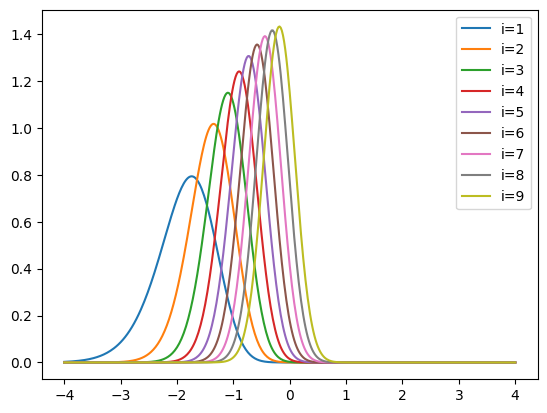

In [13]:
zgrid = np.linspace(-4, 4, 401)
for i in range(1, 10):
    pdf_vals = np.array([gaussian_orderstat_pdf(z, lam, i) for z in zgrid])
    plt.plot(zgrid, pdf_vals, label=f"i={i}")
plt.legend()
plt.show()


In [76]:
def cmaes_weights(population_size):
    """
    Computes the standard CMA-ES normalized recombination weights 
    given the population size.

    Parameters
    ----------
    population_size : int
        The total number of candidate solutions / offspring.

    Returns
    -------
    weights : np.ndarray
        The normalized weight vector (length = mu, where mu = floor(population_size/2)).
        Largest value is for the best-ranked individual.
    """
    mu = population_size // 2
    # Logarithmic weights for top mu ranks
    ranks = np.arange(1, mu+1)
    weights = np.log(mu + 0.5) - np.log(ranks)
    weights = weights / np.sum(weights)
    weights_padded = np.zeros(population_size)
    weights_padded[:mu] = weights
    return weights, weights_padded


In [ ]:
# Using the CMA-ES heuristic for population size (lambda)
dimen = 1E6
lam = int(4 + np.floor(3 * np.log2(dimen)))
print(f"dim {dimen}, lambda: {lam}")
weights, weights_padded = cmaes_weights(lam)
normal_OS_means = gaussian_orderstat_means(lam, method="u")
# reverse the order, now from biggest to smallest
weighted_OS_means = np.sum(weights_padded * normal_OS_means[::-1]) 
on_manifold_shift = weighted_OS_means
print(f"Weighted mean of Z_[1:{lam}] using CMA-ES weights [on manifold shift]: {weighted_OS_means:.8f}")
ortho_var = np.sum(weights_padded**2)
print(f"Orthogonal variance of Z_[1:{lam}] using CMA-ES weights [on manifold variance]: {ortho_var:.8f}")
print(f"off manifold norm: {ortho_var * np.sqrt(dimen-1):.8f}")
cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))
print(f"cosine with gradient: {cosine_grad:.4f}")

dim 100000.0, lambda: 53
Weighted mean of Z_[1:53] using CMA-ES weights [on manifold shift]: 1.30795973
Orthogonal variance of Z_[1:53] using CMA-ES weights [on manifold variance]: 0.06907303
off manifold norm: 21.84270013
cosine with gradient: 0.0157


In [70]:
# Using the CMA-ES heuristic for population size (lambda)
dimen = 1E6
for dimen in [1E1, 1E2, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9, 1E10, 1E11,]:
    lam = int(4 + np.floor(3 * np.log2(dimen)))
    print(f"dim {dimen}, lambda: {lam}")
    weights, weights_padded = cmaes_weights(lam)
    normal_OS_means = gaussian_orderstat_means(lam, method="u")
    # reverse the order, now from biggest to smallest
    weighted_OS_means = np.sum(weights_padded * normal_OS_means[::-1]) 
    on_manifold_shift = weighted_OS_means
    print(f"Weighted mean of Z_[1:{lam}] using CMA-ES weights [on manifold shift]: {weighted_OS_means:.8f}")
    ortho_var = np.sum(weights_padded**2)
    print(f"Orthogonal variance of Z_[1:{lam}] using CMA-ES weights [on manifold variance]: {ortho_var:.8f}")
    print(f"off manifold norm: {ortho_var * np.sqrt(dimen-1):.8f}")
    cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))
    print(f"cosine with gradient: {cosine_grad:.4f}")

dim 10.0, lambda: 13
Weighted mean of Z_[1:13] using CMA-ES weights [on manifold shift]: 1.19553354
Orthogonal variance of Z_[1:13] using CMA-ES weights [on manifold variance]: 0.26813541
off manifold norm: 0.80440623
cosine with gradient: 0.6099
dim 100.0, lambda: 23
Weighted mean of Z_[1:23] using CMA-ES weights [on manifold shift]: 1.25242798
Orthogonal variance of Z_[1:23] using CMA-ES weights [on manifold variance]: 0.15423242
off manifold norm: 1.53459323
cosine with gradient: 0.3052
dim 1000.0, lambda: 33
Weighted mean of Z_[1:33] using CMA-ES weights [on manifold shift]: 1.27974660
Orthogonal variance of Z_[1:33] using CMA-ES weights [on manifold variance]: 0.10894636
off manifold norm: 3.44346338
cosine with gradient: 0.1218
dim 10000.0, lambda: 43
Weighted mean of Z_[1:43] using CMA-ES weights [on manifold shift]: 1.29645737
Orthogonal variance of Z_[1:43] using CMA-ES weights [on manifold variance]: 0.08446282
off manifold norm: 8.44586006
cosine with gradient: 0.0446
dim 10

In [ ]:
# Using the CMA-ES heuristic for population size (lambda)
dimen = 1E6
for dimen in [1E8, 1E10, ]:
    for lam in [2, 3, 4, 5, 6, 8, 10, 30, 100, 300, 1000, ]:
        lam = int(lam)
        dimen = int(dimen)
        # lam = int(4 + np.floor(3 * np.log2(dimen)))
        print(f"dim {dimen}, lambda: {lam}")
        weights, weights_padded = cmaes_weights(lam)
        normal_OS_means = gaussian_orderstat_means(lam, method="u")
        # reverse the order, now from biggest to smallest
        weighted_OS_means = np.sum(weights_padded * normal_OS_means[::-1]) 
        on_manifold_shift = weighted_OS_means
        print(f"Weighted mean of Z_[1:{lam}] using CMA-ES weights [on manifold shift]: {weighted_OS_means:.8f}")
        ortho_var = np.sum(weights_padded**2)
        print(f"Orthogonal variance of Z_[1:{lam}] using CMA-ES weights [on manifold variance]: {ortho_var:.8f}")
        print(f"off manifold norm: {ortho_var * np.sqrt(dimen-1):.8f}")
        cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))
        print(f"cosine with gradient: {cosine_grad:.4f}")

dim 100000000, lambda: 1
Weighted mean of Z_[1:1] using CMA-ES weights [on manifold shift]: 0.00000000
Orthogonal variance of Z_[1:1] using CMA-ES weights [on manifold variance]: 0.00000000
off manifold norm: 0.00000000
cosine with gradient: nan
dim 100000000, lambda: 2
Weighted mean of Z_[1:2] using CMA-ES weights [on manifold shift]: 0.56418958
Orthogonal variance of Z_[1:2] using CMA-ES weights [on manifold variance]: 1.00000000
off manifold norm: 9999.99995000
cosine with gradient: 0.0001
dim 100000000, lambda: 3


/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_53438/3598293234.py:18: RuntimeWarning: invalid value encountered in scalar divide
  cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))


Weighted mean of Z_[1:3] using CMA-ES weights [on manifold shift]: 0.84628438
Orthogonal variance of Z_[1:3] using CMA-ES weights [on manifold variance]: 1.00000000
off manifold norm: 9999.99995000
cosine with gradient: 0.0001
dim 100000000, lambda: 4
Weighted mean of Z_[1:4] using CMA-ES weights [on manifold shift]: 0.88595130
Orthogonal variance of Z_[1:4] using CMA-ES weights [on manifold variance]: 0.68503009
off manifold norm: 6850.30087300
cosine with gradient: 0.0001
dim 100000000, lambda: 5
Weighted mean of Z_[1:5] using CMA-ES weights [on manifold shift]: 1.03215594
Orthogonal variance of Z_[1:5] using CMA-ES weights [on manifold variance]: 0.68503009
off manifold norm: 6850.30087300
cosine with gradient: 0.0001
dim 100000000, lambda: 6
Weighted mean of Z_[1:6] using CMA-ES weights [on manifold shift]: 1.00568748
Orthogonal variance of Z_[1:6] using CMA-ES weights [on manifold variance]: 0.49294802
off manifold norm: 4929.48015155
cosine with gradient: 0.0001
dim 100000000, la

In [77]:
cmaes_weights(1)

(array([], dtype=float64), array([0.]))

In [ ]:
# Using the CMA-ES heuristic for population size (lambda)
import pandas as pd

results = []
for dimen in [1E4, 1E6, 1E8, 1E10]:
    for lam in [1, 2, 3, 4, 5, 6, 8, 10, 30, 100, 300, 1000]:
        lam = int(lam)
        dimen = int(dimen)
        weights, weights_padded = cmaes_weights(lam)
        normal_OS_means = gaussian_orderstat_means(lam, method="u")
        # reverse the order, now from biggest to smallest
        weighted_OS_means = np.sum(weights_padded * normal_OS_means[::-1]) 
        on_manifold_shift = weighted_OS_means
        ortho_var = np.sum(weights_padded**2)
        off_manifold_norm = ortho_var * np.sqrt(dimen-1)
        cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))
        results.append({
            "dim": dimen,
            "lambda": lam,
            "on_manifold_shift": weighted_OS_means,
            "ortho_var": ortho_var,
            "off_manifold_norm": off_manifold_norm,
            "cosine_grad": cosine_grad
        })

df = pd.DataFrame(results)
# Format float columns for display
float_fmt = {
    "on_manifold_shift": "{:.8f}",
    "ortho_var": "{:.8f}",
    "off_manifold_norm": "{:.8f}",
    "cosine_grad": "{:.4f}",
}
display(df.style.format(float_fmt))

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_53438/4232691038.py:16: RuntimeWarning: invalid value encountered in scalar divide
  cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))


,dim,lambda,on_manifold_shift,ortho_var,off_manifold_norm,cosine_grad
0,10000,1,0.00000000,0.00000000,0.00000000,nan
1,10000,2,0.56418958,1.00000000,99.99499987,0.0056
2,10000,3,0.84628438,1.00000000,99.99499987,0.0085
3,10000,4,0.88595130,0.68503009,68.49958384,0.0107
4,10000,5,1.03215594,0.68503009,68.49958384,0.0125
5,10000,6,1.00568748,0.49294802,49.29233696,0.0143
6,10000,8,1.07177676,0.38458893,38.45697029,0.0173
7,10000,10,1.11480147,0.31572640,31.57106133,0.0198
8,10000,30,1.25540355,0.11569949,11.56937046,0.0369
9,10000,100,1.32970818,0.03708283,3.70809801,0.0689


In [104]:
# Using the CMA-ES heuristic for population size (lambda)
import pandas as pd

results = []
for lam in [2, 3, 4, 5, 6, 8, 10, 30, 100, 300, 1000]:
    lam = int(lam)
    dimen = int(dimen)
    weights, weights_padded = cmaes_weights(lam)
    normal_OS_means = gaussian_orderstat_means(lam, method="u")
    # reverse the order, now from biggest to smallest
    weighted_OS_means = np.sum(weights_padded * normal_OS_means[::-1]) 
    on_manifold_shift = weighted_OS_means
    for dimen in [1E2, 1E3, 1E4, 1E6, 1E8, 1E10]:
        ortho_var = np.sum(weights_padded**2)
        off_manifold_norm = ortho_var * np.sqrt(dimen-1)
        cosine_grad = on_manifold_shift / np.sqrt(on_manifold_shift**2 + ortho_var * (dimen-1))
        results.append({
            "dimen": int(dimen),
            "lambda": int(lam),
            "on_manifold_shift": weighted_OS_means,
            "ortho_var": ortho_var,
            "off_manifold_norm": off_manifold_norm,
            "cosine_grad": cosine_grad
        })

df = pd.DataFrame(results)
# Format float columns for display
float_fmt = {
    "on_manifold_shift": "{:.8f}",
    "ortho_var": "{:.8f}",
    "off_manifold_norm": "{:.8f}",
    "cosine_grad": "{:.4f}",
}
display(df.style.format(float_fmt))

,dimen,lambda,on_manifold_shift,ortho_var,off_manifold_norm,cosine_grad
0,100,2,0.56418958,1.00000000,9.94987437,0.0566
1,1000,2,0.56418958,1.00000000,31.60696126,0.0178
2,10000,2,0.56418958,1.00000000,99.99499987,0.0056
3,1000000,2,0.56418958,1.00000000,999.99950000,0.0006
4,100000000,2,0.56418958,1.00000000,9999.99995000,0.0001
5,10000000000,2,0.56418958,1.00000000,99999.99999500,0.0000
6,100,3,0.84628438,1.00000000,9.94987437,0.0847
7,1000,3,0.84628438,1.00000000,31.60696126,0.0268
8,10000,3,0.84628438,1.00000000,99.99499987,0.0085
9,1000000,3,0.84628438,1.00000000,999.99950000,0.0008


/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

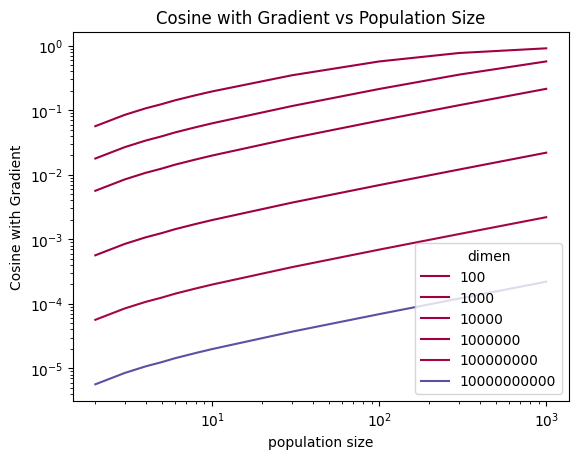

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data=df, x="lambda", y="cosine_grad", hue="dimen", legend=True, palette="Spectral")
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("population size")
plt.ylabel("Cosine with Gradient")
plt.title("Cosine with Gradient vs Population Size")
plt.show()

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

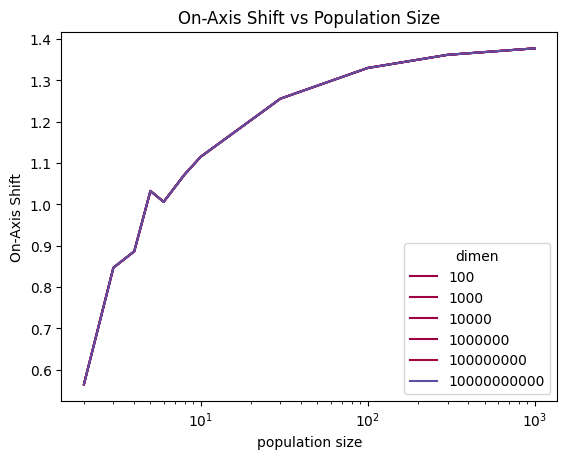

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data=df, x="lambda", y="on_manifold_shift", hue="dimen", legend=True, palette="Spectral")
ax.set_xscale('log')
plt.xlabel("population size")
plt.ylabel("On-Axis Shift")
plt.title("On-Axis Shift vs Population Size")
plt.show()

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

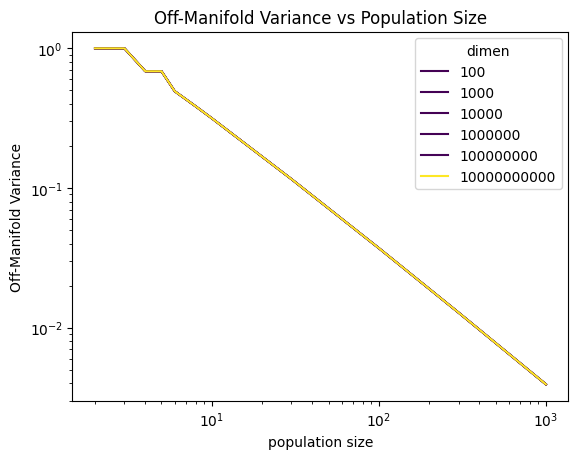

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(data=df, x="lambda", y="ortho_var", hue="dimen", legend=True, palette="viridis")
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("population size")
plt.ylabel("Off-Manifold Variance")
plt.title("Off-Manifold Variance vs Population Size")
plt.show()

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

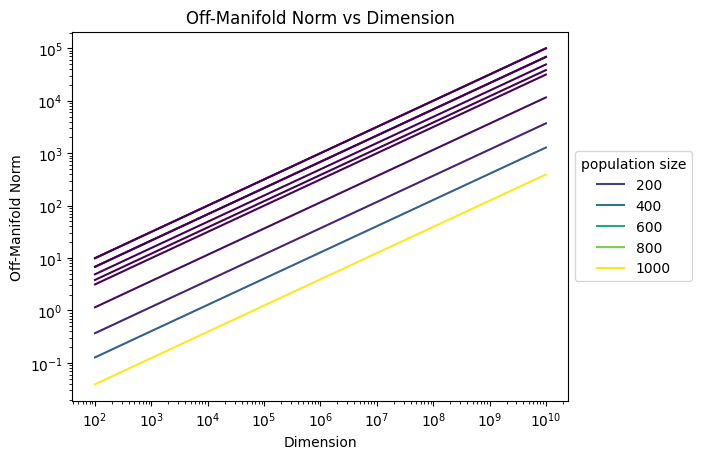

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data=df, x="dimen", y="off_manifold_norm", hue="lambda", legend=True, palette="viridis")
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(title="population size", loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Dimension")
plt.ylabel("Off-Manifold Norm")
plt.title("Off-Manifold Norm vs Dimension")
plt.show()